In [211]:
# general python ecosystem
import numpy as np
import scipy as sp
import scipy.sparse as sps
from matplotlib import pyplot as plt
from matplotlib.colors import Normalize
from matplotlib.patches import Wedge, Rectangle
from matplotlib.pyplot import cm
import ipywidgets
import random
import math

# SimPEG tools 
import discretize
from discretize import TensorMesh
from discretize.utils import mesh_builder_xyz, refine_tree_xyz
from SimPEG.potential_fields import magnetics as mag
from SimPEG.utils import mkvc, surface2ind_topo
from SimPEG import (
    data,
    data_misfit,
    directives,
    maps,
    inverse_problem,
    optimization,
    inversion,
    regularization,
    utils
)

from pymatsolver import Pardiso as Solver

Set Flags for sampling strategy and use of topography

In [212]:
inflight=2     # inflight sampling is 1; landed sampling is 0; 2 is mesh
use_topo=False 

# Forward problem

## define the geologic setup

**SimPEG conventions**
- right handed coordinate system
- z-positive up
- SI units

For this example, we assume a topography low due to the crater

In [213]:
# define MAG
target_magnetization_inclination = 45
target_magnetization_declination = 90 

target_magnetization_direction = utils.mat_utils.dip_azimuth2cartesian(
    target_magnetization_inclination, target_magnetization_declination
)

target_magnetization_amplitude = 10 # magnetization in A/m
background_magnetization = 0 # magnetization in A/m
target_magnetization = target_magnetization_amplitude * target_magnetization_direction

# define Topography if flag is set to true
[xx, yy] = np.meshgrid(np.linspace(-400, 400, 50), np.linspace(-400, 400, 50))
b = 100
A = 50

if use_topo is True:
    zz = -A * np.exp(-0.5 * ((xx / b) ** 2.0 + (yy / b) ** 2.0))
else: 
    zz = np.zeros_like(xx)
    
topo = np.c_[mkvc(xx), mkvc(yy), mkvc(zz)]

print(target_magnetization)


[[ 7.07106781  0.         -7.07106781]]


## survey geometry

In [214]:
if inflight ==1:  #inflight measuremenets 
    line_length = 200
    n_data_along_line = 30
    survey_x = np.linspace(-line_length/2, line_length/2, n_data_along_line)
    survey_y = np.r_[-5,0, 5] 
    survey_z = np.r_[10]
    survey_xyz = discretize.utils.ndgrid([survey_x, survey_y, survey_z])
    
    xx = np.linspace(0, 7, n_data_along_line)
    xx =np.concatenate([xx,xx,np.flip(xx)])
    
    survey_xyz[:,1] = (survey_xyz[:,1]*xx)+2
    survey_z = np.linspace(1, 30, int(n_data_along_line/2))
    zz = np.concatenate([survey_z, np.flip(survey_z), survey_z, np.flip(survey_z), survey_z, np.flip(survey_z)])
    survey_xyz[:,2] = zz

elif inflight == 2: # grid
    line_length = 200
    n_data_along_line = 12
    survey_x = np.linspace(-line_length/2, line_length/2, n_data_along_line)
    survey_y = survey_x
    survey_z = np.r_[5]
    survey_xyz = discretize.utils.ndgrid([survey_x, survey_y, survey_z])

else:
    line_length = 200
    n_data_along_line = 6
    survey_x = np.linspace(-line_length/2, line_length/2, n_data_along_line)
    survey_x = np.r_[-100, -50,-10,0,10,20,30,50,100] 
    
    survey_y = np.r_[5] 
    survey_z = np.r_[1]
    survey_xyz = discretize.utils.ndgrid([survey_x, survey_y, survey_z])

print(survey_y)

[-100.          -81.81818182  -63.63636364  -45.45454545  -27.27272727
   -9.09090909    9.09090909   27.27272727   45.45454545   63.63636364
   81.81818182  100.        ]


## create a mesh

Here, we use a tensor mesh 

In [215]:


nc_z = 10#5  # number of core mesh cells in x, y and z
dz = 3   # base cell width in x, y and z
npad_z = 10  # number of padding cells

nc = 40  # number of core mesh cells in x, y and z
dh = 5   # base cell width in x, y and z
npad = 10  # number of padding cells
exp = 1 # expansion rate of padding cells
exp_z = 1.4 # was 1.4

h = [(dh, npad, -exp), (dh, nc), (dh, npad, exp)]
hz = [(dz, npad_z, -exp_z), (dz, nc_z), (dz, npad_z, exp_z)]
mesh = TensorMesh([h, h, hz], x0="CCC")

# Define an active cells from topo
actv = utils.surface2ind_topo(mesh, topo)
nC = int(actv.sum())
model_map = maps.IdentityMap(nP=nC)  # model is a vlue for each active cell

mesh

TensorMesh: 108,000 cells

                      MESH EXTENT             CELL WIDTH      FACTOR
  dir    nC        min           max         min       max      max
  ---   ---  ---------------------------  ------------------  ------
   x     60       -150.00        150.00      5.00      5.00    1.00
   y     60       -150.00        150.00      5.00      5.00    1.00
   z     30       -308.22        308.22      3.00     86.78    1.40

#### put the model on the mesh and create an acive cell map to ignore air cells.  

In [216]:
xp = np.kron(np.ones((2)), [0, 15.0, 15.0, 00.0])
yp = np.kron([-5.0, 10.0], np.ones((4)))
zp = np.kron(np.ones((2)), [-600.0, -600.0, 45.0, 45.0])
xyz_pts = np.c_[mkvc(xp), mkvc(yp), mkvc(zp)]
ind2 = utils.model_builder.PolygonInd(mesh, xyz_pts)

magnetization = np.zeros((mesh.nC, 3))
magnetization[ind2, :] = target_magnetization
model = magnetization[actv, :]
active_cell_map = maps.InjectActiveCells(mesh=mesh, indActive=actv, valInactive=np.nan)

### define some useful plotting functions

In [217]:
def full_mesh_magnetization(model,nC,active_cell_map):
    return np.vstack([active_cell_map * model.reshape(nC, 3, order="F")[:, i] for i in range(3)]).T

In [218]:
def plot_vector_model(
    mesh, nC, active_cell_map, maxval, model, ax=None, quiver_opts=None, normal="Y", xlim=None, ylim=None, ind=None, plot_data=True, plot_grid=False, outline=True
):
    if ax is None: 
        fig, ax = plt.subplots(1, 1, figsize=(10, 4))

    magnetization = full_mesh_magnetization(model,nC,active_cell_map)
    qo = {
        "units":"xy", "scale":np.max(np.abs(model))/20,
        "headwidth":7, "headlength":10, "headaxislength":10
    }
    
    # overwrite default vals if user provides them 
    if quiver_opts is not None:
        for key, val in quiver_opts.items(): 
            qo[key] = val 

    cb = plt.colorbar(
        mesh.plot_slice(
            magnetization, "CCv", clim=[0,maxval],normal=normal, ax=ax, view="vec", 
            grid=plot_grid, ind=ind, quiver_opts=qo,label=False, stream_opts={"color":"k","arrowsize":2}
        )[0], ax=ax
    )
    
    #cb.set_label("amplitude magnetization (A/m)", fontsize=14)
    rect = patches.Rectangle((50, 100), 40, 30, linewidth=1, edgecolor='r', facecolor='none')
    
    if normal.upper() == "X": 
        if plot_data is True: 
            ax.plot(survey_xyz[:, 1], survey_xyz[:, 2], "C1o", ms=4,label=False)
        ax.set_xlim([survey_x.min()*1.5, survey_x.max()*1.1] if xlim is None else xlim)
        #ax.set_title(f"x at {mesh.vectorCCy[ind]} m", fontsize=14)
        if outline is True:
            rect = patches.Rectangle(( 0,-310),15, 310, edgecolor='black',linestyle="dashed",linewidth=2, facecolor='none')
            ax.add_patch(rect)
    elif normal.upper() == "Y": 
        if plot_data is True: 
            ax.plot(survey_xyz[:, 0], survey_xyz[:, 2], "C1o", ms=4,label=False)
        ax.set_xlim([survey_x.min()*1.5, survey_x.max()*1.5] if xlim is None else xlim)
        #ax.set_title("y at 0 m", fontsize=14)
        if outline is True:
            rect = patches.Rectangle(( 0,-310),15, 310, edgecolor='black',linestyle="dashed",linewidth=2, facecolor='none')
            ax.add_patch(rect)
    elif normal.upper() == "Z": 
        if plot_data is True: 
            ax.plot(survey_xyz[:, 0], survey_xyz[:, 1], "C1o", ms=4,label=False)
        ax.set_xlim([survey_x.min()*1.25, survey_x.max()*1.25] if xlim is None else xlim)
        ax.set_ylim([survey_x.min()*1.25, survey_x.max()*1.25] if ylim is None else ylim)
        #ax.set_title(f"z at {int(mesh.vectorCCz[ind])} m", fontsize=14)
        if outline is True:
            rect = patches.Rectangle((0,-5),15, 15, edgecolor='black',linestyle="dashed",linewidth=2, facecolor='none')
            ax.add_patch(rect)
    ax.tick_params(axis='both', which='major', labelsize=14)
    ax.set_title("", fontsize=14)
    ax.set_ylabel("", fontsize=14)
    ax.set_xlabel("", fontsize=14)
    ax.set_aspect(1)
    
    
def plot_amplitude(
        mesh, nC, active_cell_map, maxval, model, ax=None, quiver_opts=None, normal="Y", xlim=None, ylim=None, ind=None, plot_data=True, plot_grid=False, outline=True
    ):
        if ax is None: 
            fig, ax = plt.subplots(1, 1, figsize=(10, 4))

        qo = {
            "units":"xy", "scale":np.max(np.abs(model))/20,
            "headwidth":7, "headlength":10, "headaxislength":10
        }
        
        # overwrite default vals if user provides them 
        if quiver_opts is not None:
            for key, val in quiver_opts.items(): 
                qo[key] = val 
                
        magnetization = full_mesh_magnetization(model,nC,active_cell_map)
        Mtotal = np.sqrt(magnetization[:,0]**2 + magnetization[:,1]**2 + magnetization[:,2]**2)
                
        cb = plt.colorbar(
            mesh.plot_slice(
                Mtotal, "CC", clim=[0,maxval],normal=normal, ax=ax, view="abs", 
                grid=plot_grid, ind=ind, quiver_opts=qo
                )[0], ax=ax
            )
        
        #cb.set_label("amplitude magnetization [A/m]", fontsize=14)

        if normal.upper() == "X": 
            if plot_data is True: 
                ax.plot(survey_xyz[:, 1], survey_xyz[:, 2], "C1o", ms=4,label=False)
            ax.set_xlim([survey_x.min()*1.5, survey_x.max()*1.5] if xlim is None else xlim)
            #ax.set_title(f"x at {mesh.vectorCCy[ind]} m", fontsize=14)
            if outline is True:
                rect = patches.Rectangle(( 0,-310),15, 310, edgecolor='black',linestyle="dashed",linewidth=2, facecolor='none')
                ax.add_patch(rect)
        elif normal.upper() == "Y": 
            if plot_data is True: 
                ax.plot(survey_xyz[:, 0], survey_xyz[:, 2], "C1o", ms=4)
            ax.set_xlim([survey_x.min()*1.5, survey_x.max()*1.5] if xlim is None else xlim)
            #ax.set_title("y at 0 m", fontsize=14)
            if outline is True:
                rect = patches.Rectangle(( 0,-310),15, 310, edgecolor='black',linestyle="dashed",linewidth=2, facecolor='none')
                ax.add_patch(rect)
        elif normal.upper() == "Z": 
            if plot_data is True: 
                ax.plot(survey_xyz[:, 0], survey_xyz[:, 1], "C1o", ms=4)
            ax.set_xlim([survey_x.min()*1.25, survey_x.max()*1.25] if xlim is None else xlim)
            ax.set_ylim([survey_x.min()*1.25, survey_x.max()*1.25] if ylim is None else ylim)
            #ax.set_title(f"z at {int(mesh.vectorCCz[ind])} m", fontsize=14)
            if outline is True:
                rect = patches.Rectangle((0,-5),15, 15, edgecolor='black',linestyle="dashed",linewidth=2, facecolor='none')
                ax.add_patch(rect)
        ax.tick_params(axis='both', which='major', labelsize=14)
        ax.set_title("", fontsize=14)
        ax.set_ylabel("", fontsize=14)
        ax.set_xlabel("", fontsize=14)
        ax.set_aspect(1)

#### Now plot the model 

vectors indicate magnetization direction in `plot_vector_model` while 'plot_amplitude' will provide amplitude of magnetization. 

Note that if you would like to change the index of the slices (cross section or depth slice, you can provide an `ind` value to the `plot_vector_model` function)

<function matplotlib.pyplot.show(close=None, block=None)>

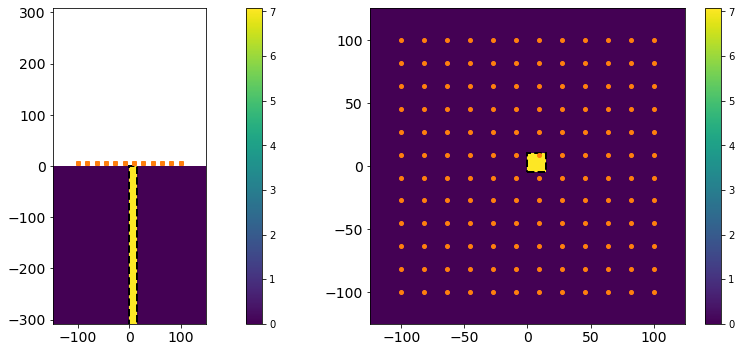

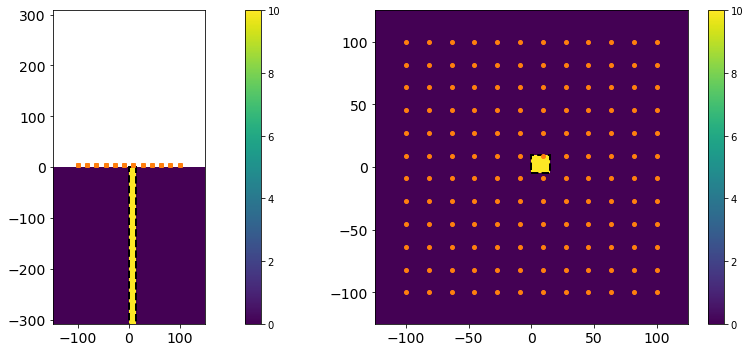

In [219]:
maxval = np.max(np.abs(model))
zind = 5
import matplotlib.patches as patches
fig, ax = plt.subplots(1, 2, figsize=(17, 5), gridspec_kw={'width_ratios': [2, 1]})
plot_vector_model(mesh, nC, active_cell_map,maxval,model, ax=ax[0],ind=(int(mesh.nCy/2)))
plot_vector_model(mesh, nC, active_cell_map,maxval,model, ax=ax[1], normal="Z", ind=zind)
plt.tight_layout()

maxval = target_magnetization_amplitude
fig, ax = plt.subplots(1, 2, figsize=(17, 5), gridspec_kw={'width_ratios': [2, 1]})
plot_amplitude(mesh, nC, active_cell_map,maxval,model, ax=ax[0],ind=(int(mesh.nCy/2)), plot_grid=False)
plot_amplitude(mesh, nC, active_cell_map,maxval,model, ax=ax[1], normal="Z", ind=zind,plot_grid=False)  # APPEND WITHOUT GRID,plot_grid=False
plt.tight_layout()
plt.savefig("../figures/Dike_model.pdf", format="pdf", bbox_inches="tight")
plt.show


## setup and run the forward simulation

### survey

We create a survey object that keeps track of what data we are measuring and where. We create a `source_field` because the code was designed thinking about "effective susceptibility" being the model parameter. The orientation makes no impact, it is only a scaling. So since the problem is linear, if we use an amplitude of 1 for the source field, then we can consider the model to be magnetization, and there is no induced component. 

In [220]:
components = ["x", "y", "z"]
rx = mag.receivers.Point(locations=survey_xyz, components=[f"b{comp}" for comp in components])

source_field = mag.sources.SourceField(
    receiver_list=[rx], parameters=np.r_[1., 0, 0]
)
survey = mag.survey.Survey(source_field)

### simulation 

The simulation object is what we use to create our synthetic data

In [221]:
simulation = mag.simulation.Simulation3DIntegral(
    mesh=mesh, survey=survey, chiMap=maps.IdentityMap(nP=np.prod(model.shape)), 
    actInd=actv, model_type="vector"
)

### run the simulation

The `synthetic_data` is an object that keeps track of the simulated data. It keeps the clean data (`synthetic_data.dclean`), the data that will be used in the inversion (`synthetic_data.dobs`), whether those data are contaminated with noise (`add_noise`), and the standard deviation of the noise. 

The standard deviation of the noise assigned here will later be used in the inversion. Note that `noise_floor` should be greater than 0. 

The data misfit that we will later construct for the inversion is as follows:
$$
\phi_d = \| \mathbf{W}_d(\mathbf{d}^{\rm pred} - \mathbf{d}^{\rm obs} )\|^2
$$

with 
- $\mathbf{W}_d = {\rm diag}(1/\epsilon_j)$
- $\epsilon_j = $ `relative_error * abs(dobs) + noise_floor`


In [222]:
synthetic_data = simulation.make_synthetic_data(
    utils.mkvc(model), 
    noise_floor=0.1, # standard deviation of the noise in nT 
    relative_error=0,  # if you want to include a percent noise 
    add_noise=True  # do we add noise to the data we will use in the inversion?
) 

In [223]:
survey_z_s = [1]
def plot_data_profile(data, plot_opts=None, ax=None, xlim=None, ylim=None, label=True):
    data = data.reshape((survey_xyz.shape[0], len(components)))
    
    if ax is None: 
        fig, ax = plt.subplots(1, len(components), figsize=(5*len(components), 4))
        ax = np.atleast_2d(ax)
    
    po = {"ms": 3}
    if plot_opts is not None: 
        for key, val in plot_opts.items():
            po[key] = val 
    cc = cm.viridis(np.linspace(0, 1, survey_y.shape[0]))

    for k, zloc in enumerate(survey_z_s): 
        for i, component in enumerate(components):
            d = data[:, i].reshape(len(survey_x), len(survey_y), len(survey_z_s), order="F")
            for j, y in enumerate(survey_y):
                if not isinstance(label, bool):
                    l=f"{y:1.0f} m {label}"
                else:
                    l=f"{y:1.0f} m" if label is True else None
                ax[k, i].plot(survey_x, d[:, j, k], color =cc[j],label=l, **po)

            #ax[k, i].set_title(f"B{component} z={zloc}m")
            ax[k, i].grid("both", alpha=0.6)
            ax[k, i].set_ylim(1.25 * np.r_[data.min(), data.max()] if ylim is None else ylim)
            ax[k, i].set_xlim(xlim)
            #ax[k, i].set_xlabel("x (m)")
    
    #ax[0, 0].set_ylabel("magnetic field (nT)")
    if label is not False: 
        ax[0, 0].legend()
    plt.tight_layout()
    return ax
    

<function matplotlib.pyplot.show(close=None, block=None)>

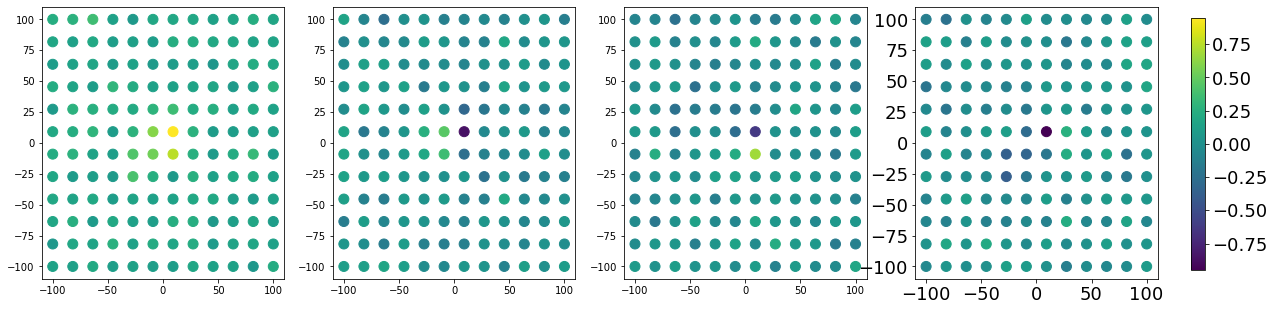

In [224]:
fig, ax = plt.subplots(1, 4, figsize=(20, 5), gridspec_kw={'width_ratios': [1,1,1, 1]})

d_obs = synthetic_data.dobs.reshape((survey_xyz.shape[0], len(components)))
B_obs = np.sqrt(d_obs[:,0]**2 + d_obs[:,1]**2 + d_obs[:,2]**2)

vvmin = np.min(d_obs)
vvmax = np.max(d_obs)

if abs(vvmin)<abs(vvmax):
    vvmin = -vvmax
    
if abs(vvmax)<abs(vvmin):
    vvmax = -vvmin
    
ax[0].scatter(survey_xyz[:, 0], survey_xyz[:, 1], marker='o',c=B_obs,s=100, cmap='viridis',vmin=vvmin,vmax=vvmax)
#ax[0].set_title("|B|")
ax[1].scatter(survey_xyz[:, 0], survey_xyz[:, 1], marker='o',c=d_obs[:,0],s=100, cmap='viridis',vmin=vvmin,vmax=vvmax)
#ax[1].set_title("Bx")
ax[2].scatter(survey_xyz[:, 0], survey_xyz[:, 1], marker='o',c=d_obs[:,1],s=100, cmap='viridis',vmin=vvmin,vmax=vvmax)
#ax[2].set_title("By")
sc =ax[3].scatter(survey_xyz[:, 0], survey_xyz[:, 1], marker='o',c=d_obs[:,2],s=100, cmap='viridis',vmin=vvmin,vmax=vvmax)
#ax[3].set_title("Bz")
plt.yticks(fontsize=18)
plt.xticks(fontsize=18)
cbaxes = fig.add_axes([0.923, 0.15, 0.01, 0.7]) 
cbar = fig.colorbar(sc,cax = cbaxes)
plt.yticks(fontsize=18)
plt.xticks(fontsize=18)
plt.savefig("../figures/Intrusion_model.pdf", format="pdf", bbox_inches="tight")
plt.show

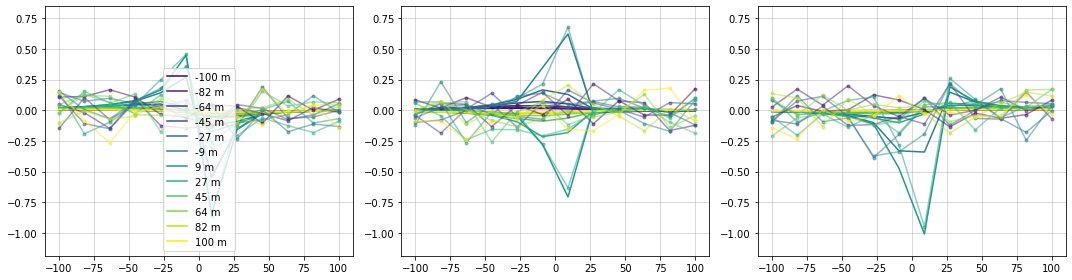

In [257]:
ax = plot_data_profile(synthetic_data.dclean,label=True)
ax = plot_data_profile(synthetic_data.dobs, ax=ax, plot_opts={"marker":"o", "alpha":0.5},label=False)

In [226]:
def plot_2d_data(data, ax=None, title=None, xlabel=True):
    if ax is None: 
        fig, ax = plt.subplots(len(survey_z_s), len(components), figsize=(2.2*len(components), 2.1), sharex=True, sharey=True)
        ax = np.atleast_2d(ax)
        
    data = data.reshape((survey_xyz.shape[0], len(components)))
    #append amplitude as last column to data
    data = np.c_[data, np.sqrt(np.sum(data**2, axis=1))]
    plotting_xyz = discretize.utils.ndgrid(survey_x, survey_y)
    
    for k, zloc in enumerate(survey_z_s):
        
        norm = Normalize(vmin=np.min(data), vmax=np.max(data))
        
        for i, component in enumerate(components): 
            d = data[:, i].reshape(len(survey_x), len(survey_y), len(survey_z_s), order="F")
            out = utils.plot2Ddata(plotting_xyz, utils.mkvc(d[:, :, k]), ax=ax[k, i], contourOpts={"norm":norm, "levels":10})
            
            if i == len(components) - 1:
                plt.colorbar(out[0], ax=ax[k, i], label="B (nT)")
        
            ax[k, i].set_title(f"B{component} {title}, z={zloc} m")
            ax[k, i].plot(survey_xyz[:, 0], survey_xyz[:, 1], "k.", ms = 2)

            if xlabel is True:
                ax[-1, i].set_xlabel("x (m)")

        ax[k, 0].set_ylabel("y (m)")
    plt.tight_layout()
    
    return ax

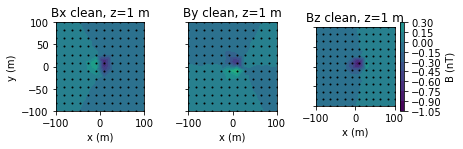

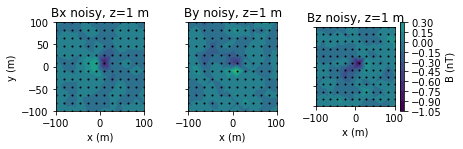

In [227]:
if len(survey_y) > 1: 
    plot_2d_data(synthetic_data.dclean, title="clean")
if len(survey_y) > 1:
    plot_2d_data(synthetic_data.dobs, title="noisy")

## Inversion 

### in cartesian coordinates 
This is a linear inverse problem if we use L2 regularization. 
We start by setting up the regularisation

In [228]:
wires = maps.Wires(("x", nC), ("y", nC), ("z", nC))

reg_x = regularization.Sparse(mesh, indActive=actv, mapping=wires.x, alpha_z=100)
reg_y = regularization.Sparse(mesh, indActive=actv, mapping=wires.y, alpha_z=100)
reg_z = regularization.Sparse(mesh, indActive=actv, mapping=wires.z, alpha_z=100)

norms = [[2, 2, 2, 2]]
reg_x.norms = norms
reg_y.norms = norms
reg_z.norms = norms

reg = reg_x + reg_y + reg_z

Data misfit

In [229]:
dmis = data_misfit.L2DataMisfit(data=synthetic_data, simulation=simulation)

Optimization

In [230]:
opt = optimization.InexactGaussNewton(
    maxIter=20, maxIterLS=20, maxIterCG=20, tolCG=1e-4
)

Set up inversion problem

In [231]:

inv_prob = inverse_problem.BaseInvProblem(dmis, reg, opt)

In [232]:
inversion.BaseInversion.directiveList

Add some directives, including 
(1) the tradeoff parameter beta
(2) add sensitivity weights 
(3) Pre-conditioner
(4) set target misfit
and put everything together. 

In [233]:

betaest = directives.BetaEstimate_ByEig(beta0_ratio=4)  
sensitivity_weights = directives.UpdateSensitivityWeights()  
IRLS = directives.Update_IRLS()  
update_Jacobi = directives.UpdatePreconditioner()  
target = directives.TargetMisfit(chifact=1)  
#save_iteration = directives.SaveModelEveryIteration()

inv = inversion.BaseInversion(
    inv_prob, directiveList=[sensitivity_weights, IRLS, update_Jacobi, betaest, target]#,save_iteration]
)

### run the inversion

In [234]:
m0 = np.zeros(nC * 3)
mrec_cartesian = inv.run(m0)

SimPEG.InvProblem will set Regularization.mref to m0.
SimPEG.InvProblem will set Regularization.mref to m0.
SimPEG.InvProblem will set Regularization.mref to m0.

        SimPEG.InvProblem is setting bfgsH0 to the inverse of the eval2Deriv.
        ***Done using same Solver and solverOpts as the problem***


/Users/annamittelholz/opt/anaconda3/envs/mars-mag/lib/python3.7/site-packages/pymatsolver/direct.py:26: PardisoTypeConversionWarning: Converting csc_matrix matrix to CSR format, will slow down.
  factor=False


model has any nan: 0
============================ Inexact Gauss Newton ============================
  #     beta     phi_d     phi_m       f      |proj(x-g)-x|  LS    Comment   
-----------------------------------------------------------------------------
x0 has any nan: 0
   0  2.36e-04  3.93e+02  0.00e+00  3.93e+02    1.75e+01      0              
Reached starting chifact with l2-norm regularization: Start IRLS steps...
eps_p: 2.8527482578590106 eps_q: 2.8527482578590106
eps_p: 2.421177461059523 eps_q: 2.421177461059523
eps_p: 2.9962029693612653 eps_q: 2.9962029693612653
------------------------- STOP! -------------------------
1 : |fc-fOld| = 0.0000e+00 <= tolF*(1+|f0|) = 3.9412e+01
0 : |xc-x_last| = 8.7365e+01 <= tolX*(1+|x0|) = 1.0000e-01
0 : |proj(x-g)-x|    = 1.7455e+01 <= tolG          = 1.0000e-01
0 : |proj(x-g)-x|    = 1.7455e+01 <= 1e3*eps       = 1.0000e-02
0 : maxIter   =      20    <= iter          =      1
------------------------- DONE! -------------------------


#### Plot those models

<function matplotlib.pyplot.show(close=None, block=None)>

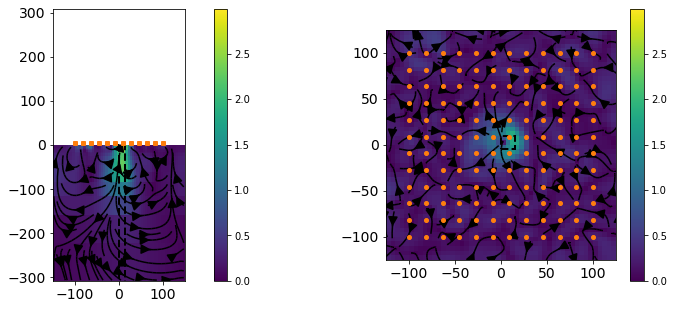

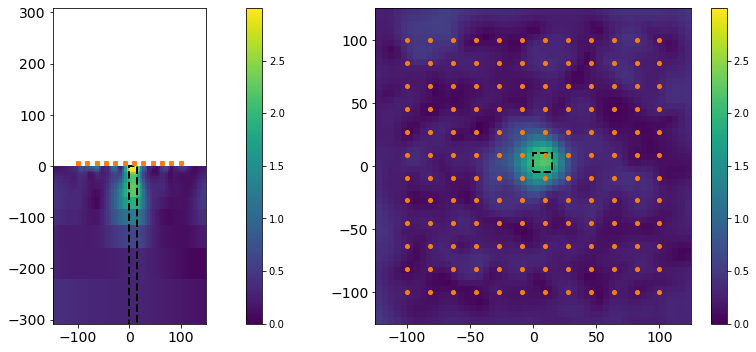

In [235]:
fig, ax = plt.subplots(1, 2, figsize=(17, 5), gridspec_kw={'width_ratios': [2, 1]})
maxval = np.max(np.abs(mrec_cartesian))
quiver_opts = {
    "scale":np.max(np.abs(mrec_cartesian))/20,
}
zind = 7
plot_vector_model(mesh, nC, active_cell_map, maxval,mrec_cartesian, ax=ax[0])
plot_vector_model(mesh, nC, active_cell_map, maxval,mrec_cartesian, ax=ax[1], normal="Z", ind=zind)


fig, ax = plt.subplots(1, 2, figsize=(17, 5), gridspec_kw={'width_ratios': [2, 1]})
quiver_opts='None'
plot_amplitude(mesh, nC, active_cell_map, maxval,mrec_cartesian, ax=ax[0])
plot_amplitude(mesh, nC, active_cell_map, maxval,mrec_cartesian, ax=ax[1], normal="Z", ind=zind)
plt.tight_layout()
plt.savefig("../figures/Intrusion_L2.pdf", format="pdf", bbox_inches="tight")
plt.show

<function matplotlib.pyplot.show(close=None, block=None)>

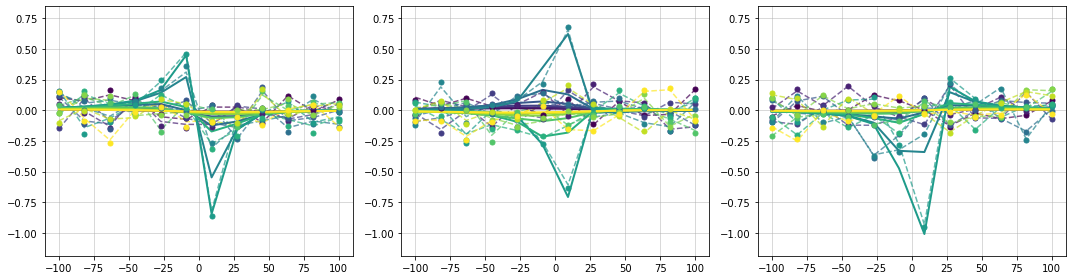

In [236]:
ax = plot_data_profile(inv_prob.dpred, plot_opts={"linestyle":"--", "alpha":0.7},label=False)
ax = plot_data_profile(synthetic_data.dclean, ax=ax,plot_opts={"lw":2},label=False)
ax = plot_data_profile(synthetic_data.dobs, ax=ax, plot_opts={"marker":"o", "lw":0,"ms":5}, label=False)
plt.savefig("../figures/Intrusion_Model_Data.pdf", format="pdf", bbox_inches="tight")
plt.show

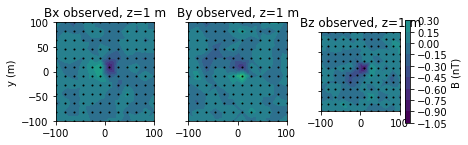

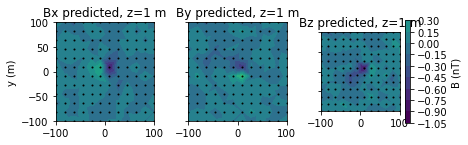

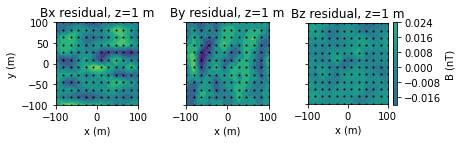

In [237]:
if len(survey_y) > 1: 
    plot_2d_data(synthetic_data.dobs, title="observed", xlabel=False)
    plot_2d_data(inv_prob.dpred, title="predicted", xlabel=False)
    plot_2d_data(synthetic_data.dobs - inv_prob.dpred, title="residual")

    plt.tight_layout()

### Sparse inversion in spherical coordinates

This allows us to impose regularization on amplitude and direction independently. 

In [238]:
## inversion in spherical coordinates
spherical_map = maps.SphericalSystem(nP=nC*3)

wires = maps.Wires(("amplitude", nC), ("theta", nC), ("phi", nC))

In [239]:
# create the regularization
reg_amplitude = regularization.Sparse(mesh, indActive=actv, mapping=wires.amplitude)
reg_theta = regularization.Sparse(mesh, indActive=actv, mapping=wires.theta)
reg_phi = regularization.Sparse(mesh, indActive=actv, mapping=wires.phi)

norms = [[1, 0, 0, 0]]
reg_amplitude.norms = norms
reg_theta.norms = norms
reg_phi.norms = norms

# set reference model to zero
reg_amplitude.mref = np.zeros(nC*3)
reg_theta.mref = np.zeros(nC*3)
reg_phi.mref = np.zeros(nC*3)

reg_amplitude.objfcts = reg_x.objfcts[:-1]
reg_theta.objfcts = reg_y.objfcts[:-1]
reg_phi.objfcts = reg_z.objfcts[:-1]

# don't impose reference angles
reg_theta.alpha_s = 0. 
reg_phi.alpha_s = 0.
reg_amplitude.alpha_s = 0.1
#reg_amplitude.alpha_z = 100


reg_spherical = reg_amplitude + reg_theta + reg_phi

In [240]:
simulation_spherical = mag.simulation.Simulation3DIntegral(
    mesh=mesh, survey=survey, chiMap=spherical_map, 
    actInd=actv, model_type="vector"
)

dmis_spherical = data_misfit.L2DataMisfit(simulation=simulation_spherical, data=synthetic_data)

In [241]:
# optimization
opt_spherical = optimization.InexactGaussNewton(
    maxIter=20, maxIterCG=20, tolCG=1e-4
)

In [242]:
inv_prob_spherical = inverse_problem.BaseInvProblem(
    dmis_spherical, reg_spherical, opt_spherical, beta=inv_prob.beta
)

In [243]:
# directives 
spherical_projection = directives.ProjectSphericalBounds()  
sensitivity_weights = directives.UpdateSensitivityWeights()
IRLS = directives.Update_IRLS(
    sphericalDomain=True, beta_tol=0.1
)
update_Jacobi = directives.UpdatePreconditioner()
save_iteration = directives.SaveModelEveryIteration()

In [244]:
inv_spherical = inversion.BaseInversion(
    inv_prob_spherical, directiveList=[
        spherical_projection, sensitivity_weights, IRLS, update_Jacobi,save_iteration
    ]
)

In [245]:
mstart = utils.cartesian2spherical(mrec_cartesian.reshape((nC, 3), order="F"))
mrec_spherical = inv_spherical.run(mstart)


        SimPEG.InvProblem is setting bfgsH0 to the inverse of the eval2Deriv.
        ***Done using same Solver and solverOpts as the problem***


/Users/annamittelholz/opt/anaconda3/envs/mars-mag/lib/python3.7/site-packages/pymatsolver/direct.py:26: PardisoTypeConversionWarning: Converting csc_matrix matrix to CSR format, will slow down.
  factor=False


SimPEG.SaveModelEveryIteration will save your models as: './###-InversionModel-2023-04-06-11-50.npy'
model has any nan: 0
============================ Inexact Gauss Newton ============================
  #     beta     phi_d     phi_m       f      |proj(x-g)-x|  LS    Comment   
-----------------------------------------------------------------------------
x0 has any nan: 0
   0  1.18e-04  6.28e+00  9.44e+04  1.74e+01    1.26e+00      0              
Reached starting chifact with l2-norm regularization: Start IRLS steps...
eps_p: 3.4904851737931173 eps_q: 3.4904851737931173
eps_p: 1.5129176673659697 eps_q: 1.5129176673659697
eps_p: 3.141095162884567 eps_q: 3.141095162884567
   1  5.89e-05  5.34e+00  1.14e+05  1.21e+01    1.40e+00      1              
   2  3.75e-03  1.73e+00  1.46e+05  5.47e+02    1.57e+01      0   Skip BFGS  
   3  3.75e-03  2.08e+02  9.80e+03  2.45e+02    2.15e+01      0              
   4  1.18e-02  5.04e+01  3.62e+04  4.76e+02    1.81e+01      0              
   5  2

##### Plotting Time
Now plot the sparse model 

27.01199961650085


<function matplotlib.pyplot.show(close=None, block=None)>

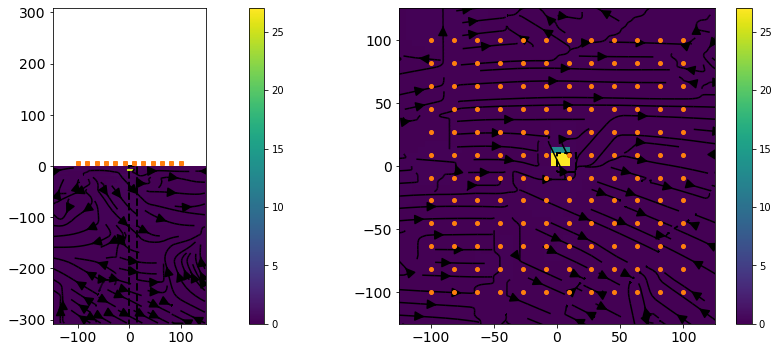

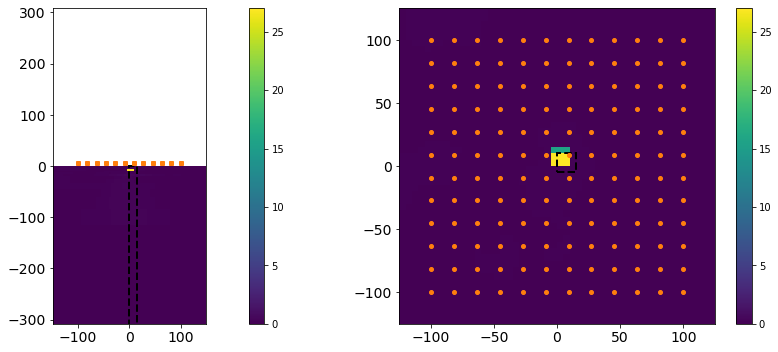

In [246]:

zind = 12
fig, ax = plt.subplots(1, 2, figsize=(18, 5), gridspec_kw={'width_ratios': [2, 1]})

quiver_opts = {
    "scale":np.max(np.abs(mrec_spherical))/20,
}

m = spherical_map * mrec_spherical
maxval =  np.max(np.abs(m))
print(np.max(np.abs(m)))

plot_vector_model(mesh, nC, active_cell_map,maxval,m, ax=ax[0])
plot_vector_model(mesh, nC, active_cell_map,maxval,m, ax=ax[1], normal="Z", ind=zind)
plt.tight_layout()

fig, ax = plt.subplots(1, 2, figsize=(18, 5), gridspec_kw={'width_ratios': [2, 1]})
quiver_opts = 'None'
plot_amplitude(mesh, nC, active_cell_map,maxval,m, ax=ax[0])
plot_amplitude(mesh, nC, active_cell_map,maxval,m, ax=ax[1], normal="Z", ind=zind)
plt.tight_layout()
plt.savefig("../figures/Intrusion_sparse.pdf", format="pdf", bbox_inches="tight")
plt.show



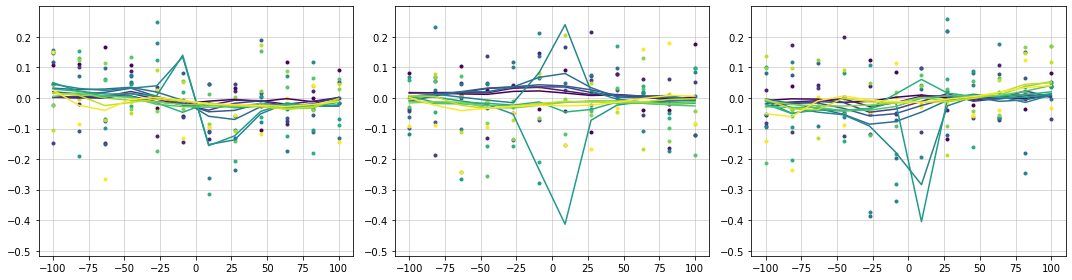

In [247]:
ax = plot_data_profile(synthetic_data.dobs, plot_opts={"marker":"o", "lw":0}, label=False)
ax = plot_data_profile(inv_prob_spherical.dpred, ax=ax, label=False)

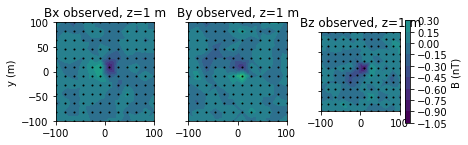

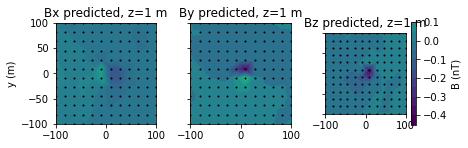

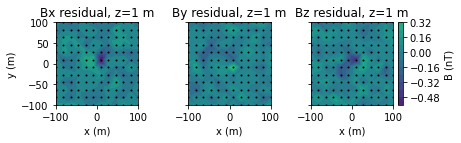

In [248]:
if len(survey_y) > 1: 
    plot_2d_data(synthetic_data.dobs, title="observed", xlabel=False)
    plot_2d_data(inv_prob_spherical.dpred, title="predicted", xlabel=False)
    plot_2d_data(synthetic_data.dobs - inv_prob_spherical.dpred, title="residual")

    plt.tight_layout()

### 1 Layer action
Now we try the 1 layer approach

make new mesh for the single layer

In [249]:

ncz = 2  # number of core mesh cells in z
dz = 308#100  # base cell width z
hz = dz * np.ones(ncz)


nc = 40  # number of core mesh cells in x, y and z
dh = 5#20   # base cell width in x, y and z
npad = 10  # number of padding cells
exp = 1  # expansion rate of padding cells

h = [(dh, npad, -exp), (dh, nc), (dh, npad, exp)]
mesh_1l = TensorMesh([h, h, hz], x0="CCC")

# Define an active cells from topo
actv_1l = utils.surface2ind_topo(mesh_1l, topo)
nC_1l = int(actv_1l.sum())
model_map = maps.IdentityMap(nP=nC_1l)  # model is a vlue for each active cell

mesh_1l



TensorMesh: 7,200 cells

                      MESH EXTENT             CELL WIDTH      FACTOR
  dir    nC        min           max         min       max      max
  ---   ---  ---------------------------  ------------------  ------
   x     60       -150.00        150.00      5.00      5.00    1.00
   y     60       -150.00        150.00      5.00      5.00    1.00
   z      2       -308.00        308.00    308.00    308.00    1.00

Magnetization in the 1 layer model 

In [250]:
ind2_1l = utils.model_builder.PolygonInd(mesh_1l, xyz_pts)

magnetization_1l = np.zeros((mesh_1l.nC, 3))
magnetization_1l[ind2_1l, :] = target_magnetization
model_1l = magnetization_1l[actv_1l, :]
active_cell_map_1l = maps.InjectActiveCells(mesh=mesh_1l, indActive=actv_1l, valInactive=np.nan)

Plot this!

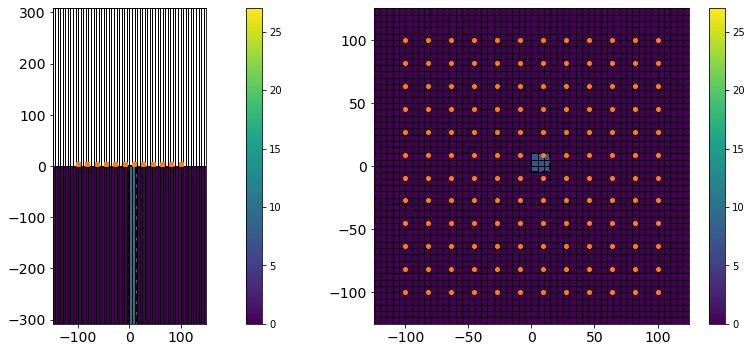

In [251]:
fig, ax = plt.subplots(1, 2, figsize=(17, 5), gridspec_kw={'width_ratios': [2, 1]})

zind = 0

plot_vector_model(mesh_1l, nC_1l, active_cell_map_1l, maxval,model_1l, ax=ax[0], plot_grid=True)
plot_vector_model(mesh_1l, nC_1l, active_cell_map_1l, maxval,model_1l, ax=ax[1], normal="Z", ind=zind,plot_grid=True)  # APPEND WITHOUT GRID,plot_grid=False
plt.tight_layout()

Create Regularisation

In [252]:
wires = maps.Wires(("x", nC_1l), ("y", nC_1l), ("z", nC_1l))

reg_x = regularization.Sparse(mesh_1l, indActive=actv_1l, mapping=wires.x,alpha_z=10)#, alpha_s=1e-4, alpha_z=1e-8)
reg_y = regularization.Sparse(mesh_1l, indActive=actv_1l, mapping=wires.y,alpha_z=10)#, alpha_s=1e-4, alpha_z=1e-8)
reg_z = regularization.Sparse(mesh_1l, indActive=actv_1l, mapping=wires.z,alpha_z=10)#, alpha_s=1e-4, alpha_z=1e-8)

norms = [[2, 2, 2, 2]]
reg_x.norms = norms
reg_y.norms = norms
reg_z.norms = norms

reg_x.objfcts = reg_x.objfcts[:-1]
reg_y.objfcts = reg_y.objfcts[:-1]
reg_z.objfcts = reg_z.objfcts[:-1]

reg = reg_x + reg_y + reg_z

# data misfit
simulation2 = mag.simulation.Simulation3DIntegral(
    mesh=mesh_1l, survey=survey, chiMap=maps.IdentityMap(nP=np.prod(model_1l.shape)), #this must be wrong!
    actInd=actv_1l, model_type="vector"
)
# simulation2.G dimensions mismatch 
dmis = data_misfit.L2DataMisfit(data=synthetic_data, simulation=simulation2)

# optimization
opt = optimization.InexactGaussNewton(
    maxIter=10, maxIterLS=10, maxIterCG=20, tolCG=1e-4
)

# inverse problem
inv_prob = inverse_problem.BaseInvProblem(dmis, reg, opt)

# directives 
betaest = directives.BetaEstimate_ByEig(beta0_ratio=8)  # estimate initial trade-off parameter
sensitivity_weights = directives.UpdateSensitivityWeights()  # Add sensitivity weights
IRLS = directives.Update_IRLS()  # IRLS
update_Jacobi = directives.UpdatePreconditioner()  # Pre-conditioner
target = directives.TargetMisfit(chifact=1)  # target misfit 


inv = inversion.BaseInversion(
    inv_prob, directiveList=[sensitivity_weights, IRLS, update_Jacobi, betaest, target]
)

 # %% run the inversion

m0 = np.zeros(nC_1l * 3)
mrec_cartesian = inv.run(m0)

SimPEG.InvProblem will set Regularization.mref to m0.
SimPEG.InvProblem will set Regularization.mref to m0.
SimPEG.InvProblem will set Regularization.mref to m0.

        SimPEG.InvProblem is setting bfgsH0 to the inverse of the eval2Deriv.
        ***Done using same Solver and solverOpts as the problem***


/Users/annamittelholz/opt/anaconda3/envs/mars-mag/lib/python3.7/site-packages/pymatsolver/direct.py:26: PardisoTypeConversionWarning: Converting csc_matrix matrix to CSR format, will slow down.
  factor=False


model has any nan: 0
============================ Inexact Gauss Newton ============================
  #     beta     phi_d     phi_m       f      |proj(x-g)-x|  LS    Comment   
-----------------------------------------------------------------------------
x0 has any nan: 0
   0  1.13e-03  3.93e+02  0.00e+00  3.93e+02    3.96e+01      0              
   1  5.64e-04  2.48e+02  4.93e+04  2.75e+02    1.28e+01      0              
Reached starting chifact with l2-norm regularization: Start IRLS steps...
eps_p: 0.8191706493132067 eps_q: 0.8191706493132067
eps_p: 0.6074446854607359 eps_q: 0.6074446854607359
eps_p: 0.9589900593053402 eps_q: 0.9589900593053402
------------------------- STOP! -------------------------
1 : |fc-fOld| = 0.0000e+00 <= tolF*(1+|f0|) = 3.9412e+01
0 : |xc-x_last| = 2.7317e+00 <= tolX*(1+|x0|) = 1.0000e-01
0 : |proj(x-g)-x|    = 1.2759e+01 <= tolG          = 1.0000e-01
0 : |proj(x-g)-x|    = 1.2759e+01 <= 1e3*eps       = 1.0000e-02
0 : maxIter   =      10    <= iter    

<function matplotlib.pyplot.show(close=None, block=None)>

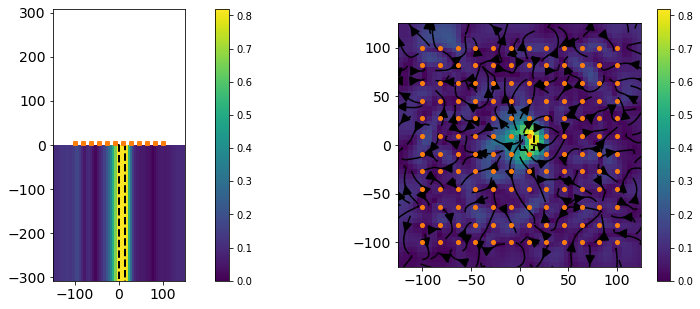

In [253]:
fig, ax = plt.subplots(1, 2, figsize=(18, 5), gridspec_kw={'width_ratios': [2, 1]})

quiver_opts = {
    "scale":np.max(np.abs(mrec_cartesian))/20,
}
maxval = np.max(mrec_cartesian)
plot_vector_model(mesh_1l, nC_1l, active_cell_map_1l, maxval,mrec_cartesian, ax=ax[0])
plot_vector_model(mesh_1l, nC_1l, active_cell_map_1l, maxval,mrec_cartesian, ax=ax[1], normal="Z",ind=0)

plt.savefig("../figures/Intrusion_1layer.pdf", format="pdf", bbox_inches="tight")
plt.show


In [254]:
spherical_map = maps.SphericalSystem(nP=nC_1l*3)
wires = maps.Wires(("amplitude", nC_1l), ("theta", nC_1l), ("phi", nC_1l))

# create the regularization
reg_amplitude = regularization.Sparse(mesh_1l, indActive=actv_1l, mapping=wires.amplitude)#, alpha_s=1e-6)
reg_theta = regularization.Sparse(mesh_1l, indActive=actv_1l, mapping=wires.theta)#, alpha_s=1e-6)
reg_phi = regularization.Sparse(mesh_1l, indActive=actv_1l, mapping=wires.phi)#, alpha_s=1e-6)

norms = [[1, 0, 0, 0]]
reg_amplitude.norms = norms
reg_theta.norms = norms
reg_phi.norms = norms

# set reference model to zero
reg_amplitude.mref = np.zeros(nC_1l*3)
reg_theta.mref = np.zeros(nC_1l*3)
reg_phi.mref = np.zeros(nC_1l*3)

reg_amplitude.objfcts = reg_x.objfcts[:-1]
reg_theta.objfcts = reg_y.objfcts[:-1]
reg_phi.objfcts = reg_z.objfcts[:-1]

# don't impose reference angles
reg_theta.alpha_s = 0. 
reg_phi.alpha_s = 0.
reg_amplitude.alpha_s = 0.1

reg_spherical = reg_amplitude + reg_theta + reg_phi

Set up the inversion

In [255]:
simulation_spherical = mag.simulation.Simulation3DIntegral(
    mesh=mesh_1l, survey=survey, chiMap=spherical_map, 
    actInd=actv_1l, model_type="vector"
)

dmis_spherical = data_misfit.L2DataMisfit(simulation=simulation_spherical, data=synthetic_data)


# In[63]:

opt_spherical = optimization.InexactGaussNewton(
    maxIter=20, maxIterCG=20, tolCG=1e-4
)
inv_prob_spherical = inverse_problem.BaseInvProblem(
    dmis_spherical, reg_spherical, opt_spherical, beta=inv_prob.beta
)

# directives 
spherical_projection = directives.ProjectSphericalBounds()  
sensitivity_weights = directives.UpdateSensitivityWeights()
IRLS = directives.Update_IRLS(
    sphericalDomain=True, beta_tol=0.1
)
update_Jacobi = directives.UpdatePreconditioner()

# %% RUN the inversion
inv_spherical = inversion.BaseInversion(
    inv_prob_spherical, directiveList=[
        spherical_projection, sensitivity_weights, IRLS, update_Jacobi
    ]
)

mstart = utils.cartesian2spherical(mrec_cartesian.reshape((nC_1l, 3), order="F"))
mrec_spherical = inv_spherical.run(mstart)


        SimPEG.InvProblem is setting bfgsH0 to the inverse of the eval2Deriv.
        ***Done using same Solver and solverOpts as the problem***


/Users/annamittelholz/opt/anaconda3/envs/mars-mag/lib/python3.7/site-packages/pymatsolver/direct.py:26: PardisoTypeConversionWarning: Converting csc_matrix matrix to CSR format, will slow down.
  factor=False


model has any nan: 0
============================ Inexact Gauss Newton ============================
  #     beta     phi_d     phi_m       f      |proj(x-g)-x|  LS    Comment   
-----------------------------------------------------------------------------
x0 has any nan: 0
   0  2.82e-04  1.95e+02  1.55e+05  2.38e+02    1.88e+01      0              
Reached starting chifact with l2-norm regularization: Start IRLS steps...
eps_p: 1.1308236213407374 eps_q: 1.1308236213407374
eps_p: 1.5699454107082793 eps_q: 1.5699454107082793
eps_p: 3.1412733282315997 eps_q: 3.1412733282315997
   1  1.41e-04  1.84e+02  3.86e+05  2.38e+02    1.93e+01      3              
   2  2.25e-04  1.81e+02  7.59e+05  3.52e+02    2.70e+01      1              
   3  3.52e-04  1.91e+02  6.42e+05  4.17e+02    2.91e+01      1              
   4  2.51e-04  3.21e+02  2.50e+05  3.83e+02    2.36e+01      0              
   5  1.92e-04  2.75e+02  2.13e+05  3.16e+02    2.13e+01      1              
   6  1.46e-04  2.82e+02  3.

And plot the recovered model 

<function matplotlib.pyplot.show(close=None, block=None)>

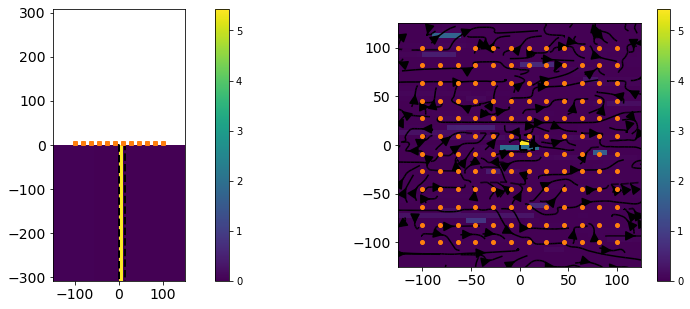

In [256]:
m = spherical_map * mrec_spherical

fig, ax = plt.subplots(1, 2, figsize=(18, 5), gridspec_kw={'width_ratios': [2, 1]})

quiver_opts = {
    "scale":np.max(np.abs(m))/20,
}
maxval =np.max(m)
plot_vector_model(mesh_1l, nC_1l, active_cell_map_1l, maxval,m, ax=ax[0])
plot_vector_model(mesh_1l, nC_1l, active_cell_map_1l, maxval,m, ax=ax[1], normal="Z",ind=0)


plt.savefig("../figures/Intrusion_1layer_sparse.pdf", format="pdf", bbox_inches="tight")
plt.show